In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer

from sklearn import linear_model
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Data Analysis

### Import cleaned data file

In [115]:
data=pd.read_csv('C:/Users/Anne_2/Documents/Ironhack/Fifa_Moneyball-Case-Study/fifa21_cleaned.csv')

In [116]:
#view data
data.head()

,id,name,age,ova,nationality,club,bp,height,weight,foot,...,gk_reflexes,pac,sho,pas,dri,def,phy,gender,position,market_value
0,16,Luis García,37,71,Spain,KAS Eupen,CM,"5'10""",143lbs,Right,...,11,53,69,73,69,58,63,Male,midfielder,600000
1,41,Iniesta,36,81,Spain,Vissel Kobe,CAM,"5'7""",150lbs,Right,...,7,58,70,85,85,63,59,Male,midfielder,5500000
2,80,E. Belözoğlu,38,77,Turkey,Fenerbahçe SK,CM,"5'7""",159lbs,Left,...,8,44,71,83,77,62,66,Male,midfielder,2800000
3,330,R. Keane,35,80,Republic of Ireland,LA Galaxy,CF,"5'9""",161lbs,Right,...,16,68,82,75,82,31,69,Male,forward,5500000
4,1179,G. Buffon,42,82,Italy,Juventus,GK,"6'4""",203lbs,Right,...,78,77,76,74,78,33,91,Male,keeper,2200000


#### There are 34 'basic' skills in the data set with a score between 0 and 100. There are also 6 indices (pac,	sho, pas, dri, def, phy) in the data which are calculated using the 34 basic skills - also having a range from 0 to 100. In the original data set there are another 6 indices out of the 34 basic skills in a different composition but these indices have a different range (values can be higher than 100).

#### Since the calculation method of the indices in the data set isn't 100% clear, the analysis will start with a factor analysis of the 34 basic skills, so that the factors can be used in a regression analysis on market value. This will also allow a more detailed analysis than using the already calculated indices.

## Factor Analysis of basic skills

In [117]:
data.columns

Index(['id', 'name', 'age', 'ova', 'nationality', 'club', 'bp', 'height',
       'weight', 'foot', 'value', 'wage', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'fk_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'composure',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'pac',
       'sho', 'pas', 'dri', 'def', 'phy', 'gender', 'position',
       'market_value'],
      dtype='object')

In [118]:
#Standardize variables for factor analysis
factors=data[['crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'fk_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'composure',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]
transformer = StandardScaler().fit(factors)
factors = pd.DataFrame(transformer.transform(factors), columns=factors.columns)

In [119]:
#Bartlett test - are variables uncorrelated?
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(factors)
print('Chi_square:', chi_square_value, '; p_value:', p_value)

Chi_square: 952138.0277382656 ; p_value: 0.0


In [120]:
#KMO test - measure of sampling adequacy for whole model (should be at least 0.5, best between 0.85 and 1) 
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_model=calculate_kmo(factors)
print(kmo_model)

(array([0.98485722, 0.9735765 , 0.96127388, 0.96897364, 0.98660319,
       0.97865371, 0.97894585, 0.97461468, 0.96483791, 0.97534515,
       0.92567189, 0.92861419, 0.97700916, 0.94116326, 0.96081127,
       0.96725576, 0.86313271, 0.98784614, 0.83548833, 0.97499623,
       0.98522153, 0.96267473, 0.97834688, 0.98133366, 0.98628811,
       0.98095728, 0.98076446, 0.91272765, 0.9133567 , 0.98011016,
       0.98216667, 0.98495641, 0.98205937, 0.97996642]), 0.9705493736318477)


C:\Users\Anne_2\anaconda3\lib\site-packages\factor_analyzer\utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


#### --> MSA per variable, as well as KMO for whole model way above 0.5, all variables can be taken into account

In [121]:
#Choosing number of factors - could choose 6 factors, to replicate the given indices in dataset or
#using Kaiser Criterion to choose factors based on eigenvalues (eigenvalue > 1)

#Initial Factor analysis with as many factors as variables
fa = FactorAnalyzer(n_factors=34, rotation=None, method='principal')
fa.fit(factors)

#get the Eigenvalues
fa.get_eigenvalues()

(array([17.98661373,  5.19784172,  2.91563142,  1.87221083,  1.38052917,
         0.61371814,  0.4555    ,  0.34778241,  0.31626853,  0.2852002 ,
         0.26526281,  0.24245119,  0.20975631,  0.2005312 ,  0.19672804,
         0.17405565,  0.15603434,  0.13517231,  0.12960107,  0.12096537,
         0.10550594,  0.09148513,  0.08968179,  0.07753629,  0.0652116 ,
         0.06232297,  0.06099747,  0.05682985,  0.03820303,  0.03450464,
         0.03282465,  0.03227828,  0.02830259,  0.02246133]),
 array([17.98661373,  5.19784172,  2.91563142,  1.87221083,  1.38052917,
         0.61371814,  0.4555    ,  0.34778241,  0.31626853,  0.2852002 ,
         0.26526281,  0.24245119,  0.20975631,  0.2005312 ,  0.19672804,
         0.17405565,  0.15603434,  0.13517231,  0.12960107,  0.12096537,
         0.10550594,  0.09148513,  0.08968179,  0.07753629,  0.0652116 ,
         0.06232297,  0.06099747,  0.05682985,  0.03820303,  0.03450464,
         0.03282465,  0.03227828,  0.02830259,  0.02246133]))

#### --> there are 5 factors with eigenvalue > 1

In [122]:
#Factor analyses with 5 factors
fa = FactorAnalyzer(n_factors=5, method='principal', rotation='varimax')
fa.fit(factors)

#get the loadings of variables on factors
print(pd.DataFrame(fa.loadings_,index=factors.columns))

                         0         1         2         3         4
crossing          0.643650  0.347824  0.295736  0.442734 -0.092804
finishing         0.790059 -0.211829  0.419906  0.256194  0.084392
heading_accuracy  0.316499  0.360751  0.631702 -0.089702  0.484240
short_passing     0.685116  0.478592  0.362435  0.242420  0.052232
volleys           0.819765 -0.109093  0.384100  0.199943  0.089734
dribbling         0.699704  0.171399  0.456900  0.444271  0.000904
curve             0.797124  0.165951  0.276569  0.319130 -0.086110
fk_accuracy       0.791537  0.188275  0.237021  0.198502 -0.148101
long_passing      0.646977  0.595788  0.171263  0.176542 -0.061047
ball_control      0.705938  0.292733  0.474901  0.335497  0.070893
acceleration      0.285960  0.003674  0.316261  0.837561  0.093569
sprint_speed      0.253357  0.004832  0.352326  0.785077  0.181855
agility           0.462543  0.033167  0.184974  0.784353 -0.022313
reactions         0.631177  0.312883 -0.344322  0.010002  0.40

#### --> the last 5 variables - skills for goalkeeping - are all loading negatively on the extracted factors, especially on factor 3, which has only "heading_accuracy" loading above 0.5 in positive direction. It makes interpretation of this factor complicated - 'bad goalkeeper' isn't a desirable skill. Explanation could be, that goalkeeper skills are so different and contrary to all other skills, that good keepers always are terrible forwards/midfielders/defenders and the other way around. Taking goalkeeping skills out of factor analysis and let them be their own skill set.

### Factor Analysis for player skills

In [123]:
#two new subsets: factors_player and factors_keeper
#starting with factors_player
factors_player=data[['crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'fk_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'composure',
       'marking', 'standing_tackle', 'sliding_tackle']]

#Bartlett test - are variables uncorrelated?
chi_square_value,p_value=calculate_bartlett_sphericity(factors_player)
print('Chi_square:', chi_square_value, '; p_value:', p_value)
                    
#KMO test - measure of sampling adequacy for whole model (should be at least 0.5, best between 0.85 and 1) 
kmo_all,kmo_model=calculate_kmo(factors_player)
print('KMO:', kmo_model)

Chi_square: 710654.9723194506 ; p_value: 0.0
KMO: 0.9595284119697213


In [124]:
#Choosing number of factors (Eigenvalue >1)
fa = FactorAnalyzer(n_factors=29, method='principal', rotation=None)
fa.fit(factors_player)
fa.get_eigenvalues()

(array([14.89284686,  5.04034595,  2.29505466,  1.47448115,  0.98138129,
         0.60512217,  0.41971542,  0.34380248,  0.31611884,  0.28504897,
         0.26366392,  0.24202135,  0.2092924 ,  0.19954051,  0.19093151,
         0.16383489,  0.14617914,  0.13228622,  0.12525016,  0.10948954,
         0.09313374,  0.08974319,  0.0782919 ,  0.0651808 ,  0.0623171 ,
         0.06103464,  0.05681458,  0.0345929 ,  0.02248371]),
 array([14.89284686,  5.04034595,  2.29505466,  1.47448115,  0.98138129,
         0.60512217,  0.41971542,  0.34380248,  0.31611884,  0.28504897,
         0.26366392,  0.24202135,  0.2092924 ,  0.19954051,  0.19093151,
         0.16383489,  0.14617914,  0.13228622,  0.12525016,  0.10948954,
         0.09313374,  0.08974319,  0.0782919 ,  0.0651808 ,  0.0623171 ,
         0.06103464,  0.05681458,  0.0345929 ,  0.02248371]))

#### --> 4 factors with eigenvalue > 1

In [125]:
#Factor analyses with 4 factors
fa = FactorAnalyzer(n_factors=4, method='principal', rotation='varimax')
fa.fit(factors_player)

#get the loadings of variables on factors
print(pd.DataFrame(fa.loadings_,index=factors_player.columns))

                         0         1         2         3
crossing          0.650347  0.380941  0.505232 -0.085080
finishing         0.826430 -0.163532  0.405635  0.147599
heading_accuracy  0.398617  0.429442  0.135760  0.629985
short_passing     0.713098  0.514139  0.327399  0.082487
volleys           0.852893 -0.066705  0.334144  0.144573
dribbling         0.731348  0.223408  0.570858  0.048847
curve             0.808359  0.195142  0.389436 -0.073490
fk_accuracy       0.803335  0.212157  0.262803 -0.130138
long_passing      0.651537  0.607760  0.189209 -0.073706
ball_control      0.745490  0.344031  0.467003  0.127036
acceleration      0.281751  0.045997  0.895761  0.076780
sprint_speed      0.255383  0.051333  0.863544  0.180233
agility           0.445260  0.056414  0.785352 -0.079296
reactions         0.577737  0.256044 -0.161985  0.240972
balance           0.340467  0.122374  0.756895 -0.224516
shot_power        0.857086 -0.060202  0.046724  0.154448
jumping          -0.036929  0.1

#### Factor loadings sorted
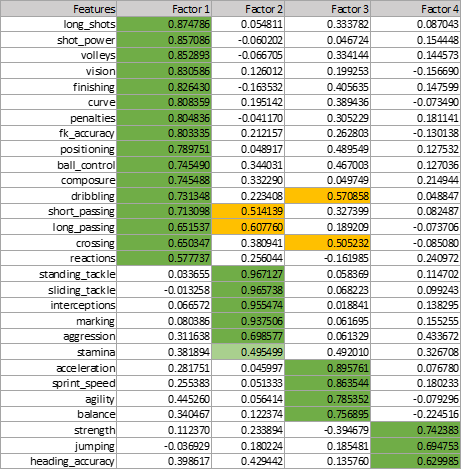

#### --> Factor 1: technical skills; --> Factor 2: duel skills; --> Factor 3: movement/running; --> Factor 4: header&strength

In [126]:
#get the variance explained by factors
print(pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                          0         1         2         3
Variance          10.393337  5.951830  5.158396  2.199166
Proportional Var   0.358391  0.205236  0.177876  0.075833
Cumulative Var     0.358391  0.563626  0.741502  0.817335


#### --> 82% of total variance is explained by the 4 extracted factors

In [127]:
#get the communalities of variables (variance of each variable explained by factors)
print(pd.DataFrame(fa.get_communalities(),index=factors_player.columns,columns=['Communalities']))

                  Communalities
crossing               0.830565
finishing              0.896055
heading_accuracy       0.758629
short_passing          0.886843
volleys                0.864429
dribbling              0.913046
curve                  0.848586
fk_accuracy            0.776358
long_passing           0.835105
ball_control           0.908343
acceleration           0.889783
sprint_speed           0.846047
agility                0.824504
reactions              0.483645
balance                0.754190
shot_power             0.764257
jumping                0.550930
stamina                0.740174
strength               0.774237
long_shots             0.887241
aggression             0.776961
interceptions          0.936843
positioning            0.882023
vision                 0.770005
penalties              0.775432
composure              0.714845
marking                0.913290
standing_tackle        0.953031
sliding_tackle         0.947330


#### --> very high communalities, for most variables more than 70% of veriance is explained by factors - variable reactions is only one with communality slightly below 0.5

In [128]:
#save factors to dataframe
player_skills=pd.DataFrame(fa.transform(factors_player), columns=['ball_play', 'duel_skills', 'movement_running', 'heading_strength'])
data=pd.concat([data, player_skills], axis=1)
data.head()

,id,name,age,ova,nationality,club,bp,height,weight,foot,...,dri,def,phy,gender,position,market_value,ball_play,duel_skills,movement_running,heading_strength
0,16,Luis García,37,71,Spain,KAS Eupen,CM,"5'10""",143lbs,Right,...,69,58,63,Male,midfielder,600000,1.935830,0.550619,-1.122184,-1.174252
1,41,Iniesta,36,81,Spain,Vissel Kobe,CAM,"5'7""",150lbs,Right,...,85,63,59,Male,midfielder,5500000,2.443800,0.988073,-1.021391,-2.188107
2,80,E. Belözoğlu,38,77,Turkey,Fenerbahçe SK,CM,"5'7""",159lbs,Left,...,77,62,66,Male,midfielder,2800000,2.356523,1.013823,-1.424733,-1.415393
3,330,R. Keane,35,80,Republic of Ireland,LA Galaxy,CF,"5'9""",161lbs,Right,...,82,31,69,Male,forward,5500000,2.442596,-0.950986,-0.310438,0.207694
4,1179,G. Buffon,42,82,Italy,Juventus,GK,"6'4""",203lbs,Right,...,78,33,91,Male,keeper,2200000,-0.444883,-1.174005,-2.250958,-0.175534


### Factor for goalkeeping skills

In [129]:
factors_keeper=data[['gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]

#Bartlett test - are variables uncorrelated?
chi_square_value,p_value=calculate_bartlett_sphericity(factors_keeper)
print('Chi_square:', chi_square_value, '; p_value:', p_value)
                    
#KMO test - measure of sampling adequacy for whole model (should be at least 0.5, best between 0.85 and 1) 
kmo_all,kmo_model=calculate_kmo(factors_keeper)
print('KMO:', kmo_model)

Chi_square: 201496.67996465872 ; p_value: 0.0
KMO: 0.9376637080925971


In [130]:
#Choosing number of factors (Eigenvalue >1) --> expecting only one factor
fa = FactorAnalyzer(n_factors=5, rotation=None)
fa.fit(factors_keeper)
fa.get_eigenvalues()

(array([4.86770109, 0.0385936 , 0.03295944, 0.03237889, 0.02836697]),
 array([4.83946192e+00, 6.95567508e-03, 4.57590605e-03, 4.21728796e-03,
        3.52896069e-03]))

#### --> one factor for goalkeeping

In [131]:
#Factor analyses with 1 factors
fa = FactorAnalyzer(n_factors=1, method='principal', rotation=None)
fa.fit(factors_keeper)

#get the loadings of variables on factors
print(pd.DataFrame(fa.loadings_,index=factors_keeper.columns))

                       0
gk_diving       0.987663
gk_handling     0.986850
gk_kicking      0.984436
gk_positioning  0.986657
gk_reflexes     0.987797


#### --> all 5 variables have almost identical, very high loading on the one factor

In [132]:
#save the factor goalkeeping to dataset
goalkeeping=pd.DataFrame(fa.transform(factors_keeper), columns=['goalkeeping_skills'])
data=pd.concat([data, goalkeeping], axis=1)

In [133]:
#check all 5 factors created
data[['ball_play', 'duel_skills', 'movement_running', 'heading_strength', 'goalkeeping_skills']].describe()

,ball_play,duel_skills,movement_running,heading_strength,goalkeeping_skills
count,1.668700e+04,1.668700e+04,1.668700e+04,1.668700e+04,1.668700e+04
mean,3.652618e-17,-2.735538e-16,2.036385e-16,-5.282558e-16,5.909391e-17
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.696829e+00,-2.132390e+00,-4.113116e+00,-3.624270e+00,-8.950556e-01
25%,-7.627787e-01,-9.716734e-01,-5.355386e-01,-6.939921e-01,-3.663177e-01
50%,3.371794e-02,2.593141e-01,1.569403e-01,-4.006023e-03,-3.030867e-01
75%,7.061548e-01,8.547248e-01,6.939403e-01,7.060041e-01,-2.292014e-01
max,4.007331e+00,2.115340e+00,2.623210e+00,3.409673e+00,4.468833e+00


## Regression Analysis of extracted factors on market value

### Checking linear relationship

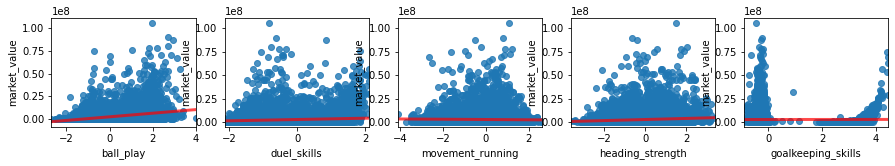

In [134]:
fig, ax = plt.subplots(1,5, figsize=(15,2))
sns.regplot(ax=ax[0], x=data['ball_play'], y=data['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
sns.regplot(ax=ax[1], x=data['duel_skills'], y=data['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
sns.regplot(ax=ax[2], x=data['movement_running'], y=data['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
sns.regplot(ax=ax[3], x=data['heading_strength'], y=data['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
sns.regplot(ax=ax[4], x=data['goalkeeping_skills'], y=data['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
plt.show()

#### --> the only fairly linear relationship is for ball_play. Trying if results are better, when splitting dataset by player position

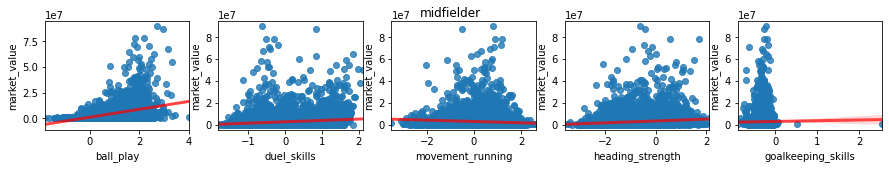

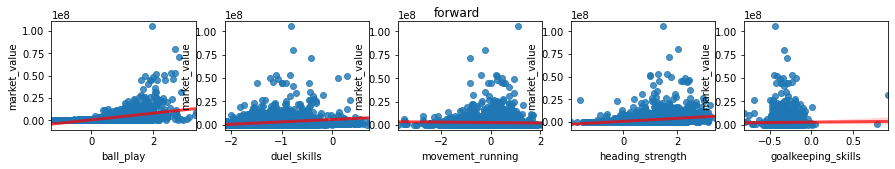

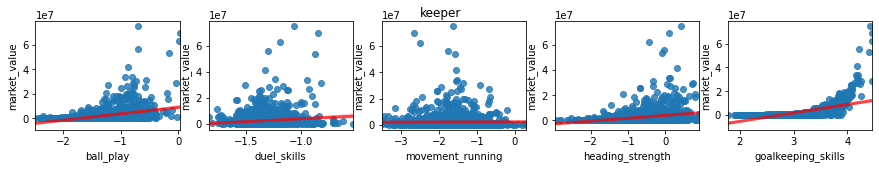

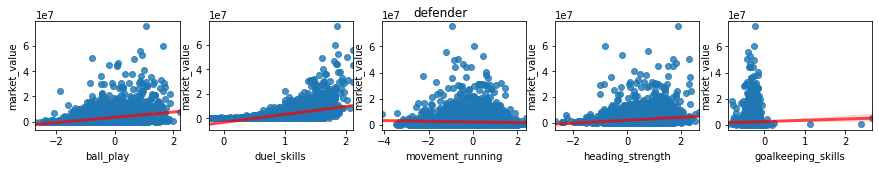

In [139]:
positions = data.groupby(data.position)
for i in data['position'].unique():
    subdata = positions.get_group(i)
    fig, ax = plt.subplots(1,5, figsize=(15,2))
    fig.suptitle(i)
    sns.regplot(ax=ax[0], x=subdata['ball_play'], y=subdata['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
    sns.regplot(ax=ax[1], x=subdata['duel_skills'], y=subdata['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
    sns.regplot(ax=ax[2], x=subdata['movement_running'], y=subdata['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
    sns.regplot(ax=ax[3], x=subdata['heading_strength'], y=subdata['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
    sns.regplot(ax=ax[4], x=subdata['goalkeeping_skills'], y=subdata['market_value'], line_kws={"color":"r","alpha":0.7,"lw":3})
    plt.show()

#### --> subplots by position show, that goalkeeping skills are only linear related to market value for position keeper. Also duel_skills seems to be much more linear related to market value for defender position, than for the other positions. Movement_running seems not form a strong linear relationship for any of the positions.

### Checking correlations matrix for each position

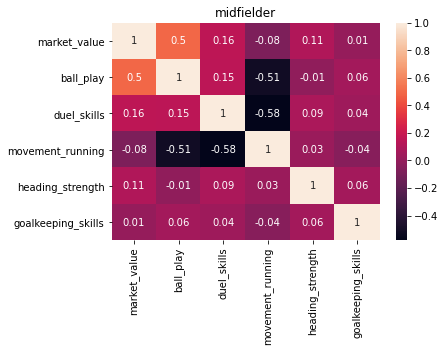

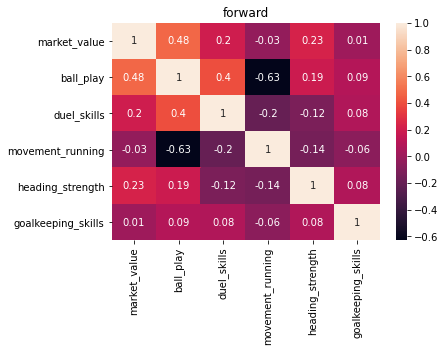

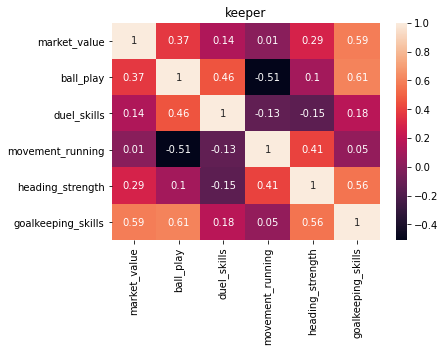

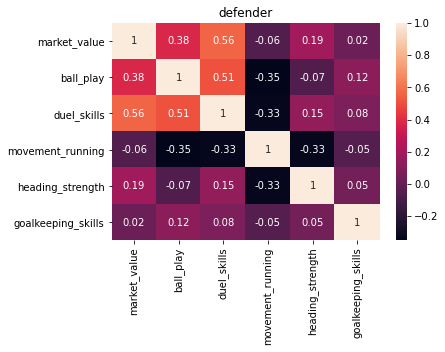

In [142]:
positions = data.groupby(data.position)
for i in data['position'].unique():
    subdata = positions.get_group(i)
    regression_data=subdata[['market_value', 'ball_play', 'duel_skills', 'movement_running', 'heading_strength', 'goalkeeping_skills']]
    plt.title(i)
    sns.heatmap(round(regression_data.corr(),2), annot=True, annot_kws={"size": 10})
    plt.show()

#### --> correlation matrix shows, that correlation of skills to target differ by position. But there is also correlation between the features after splitting the data into groups, it would make more sense, to also do the factor analysis already seperate by groups to attain uncorrelated features. If checking the heatmap for all data (no split by position), it is noticable that all features from the factor analysis for players are uncorrelated but already the seperate factor goalkeeping has a negative correlation to all other features.

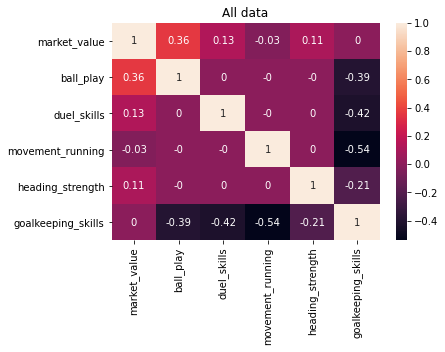

In [144]:
regression_data=data[['market_value', 'ball_play', 'duel_skills', 'movement_running', 'heading_strength', 'goalkeeping_skills']]
plt.title('All data')
sns.heatmap(round(regression_data.corr(),2), annot=True, annot_kws={"size": 10})
plt.show()